# **1. Preprocessing MEG Python**

Jupyter notebook with the **entire preprocessing and source reconstruction pipeline** for the SDMT dataset using the OSL Python library from the Oxford Centre for Human Brain Activity (OHBA) Ananalysis Group.

**Reference**: Quinn, A. J., van Es, M. W., Gohil, C., & Woolrich, M. W. (2023). OHBA Software Library in Python (OSL) (Version 0.2.0) [Computer software]. https://doi.org/10.5281/zenodo.6875060

### **Required input files/folders to run this Notebook**:
- **raw_dataset_dir**: folder containing all raw. fif files for the SDMT data
- **T1_niifiles**: folder containing all the subjects' MRI scans (.nii files)
- **T1_MNI_niifiles**: folder containing all the subjects' already co-registered MRI scans in MATLAB (.nii.gz files)
- **parcellation file**: "fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz" **with 38 parcels** needs to be 4D (3 dimensions for spatial coordinates and 1 for each parcel) with sform_code = 1
- **Parcels_38_names.txt (extra)**: .txt file with the names of the 38 parcels of the parcellation file

#### **Install necessary packages**

In [1]:
#!pip install mne
#!pip install fieldtrip2mne
#!pip install fslpy
#!pip install osl                 #(from https://github.com/OHBA-analysis/osl/tree/main)
#!pip install numpy --upgrade
#!pip install pymatreader
#!pip install trame
#!pip install ipywidgets
#!pip install numpy==1.22.4
#!pip install pandas~=1.3.5
#!pip install numba~=0.53.1

#### **Import needed packages**

In [8]:
import os
import glob
import mne
import numpy
import shutil
import osl
# opencv_python should be in same directory as the Jupyterlab Notebook
import opencv_python     # opencv_python is a manually edited package (containing cv2),only current fix to a bug 
                         # stackoverflow.com/questions/68916893/typeerror-numpy-dtypemeta-object-is-not-subscriptable
                         # https://github.com/opencv/opencv/issues/23822 
                         # should be fixed in release 4.9.x of opencv-python

### Load in dataset - raw .fif files for all patients

In [4]:
raw_dataset_dir = "/home/data/vub_ms/MEGDATA_ANA/SDMT/DATA/"

all_fif_files = sorted(glob.glob(raw_dataset_dir + '*.fif'))
print(len(all_fif_files))

139


### Remove subjects that should be excluded

In [5]:
# The subjects excluded in the preprocessing phase relate to prior findings by: Master student Sarah Dierickx (2023), PhD student Fahimeh Akbarian from AIMS VUB. 
# - issues with MRI scan
# - issues in the headmodelling step
# - missing DIODE channel (in the event extraction)
subject_IDs_to_exclude = ['2304', '2180', '2202', '2357', '2371', '1035', '0930', '2383',
                          '1063', '2174',
                          '2412', '2413', '2233', '2234']
file_IDs = []
for filename in all_fif_files:
    file_IDs.append(filename[-21:-17])  #gets the 'code' Number per patient using the filepath
    
# Function to quickly find matching elements between 2 lists
def find_matching_index(list1, list2):

    inverse_index = { element: index for index, element in enumerate(list1) }

    return [index
        for index,element in enumerate(list2) if element in inverse_index]

# Use the function to find which subject IDs have to be removed from the total list of subject IDs
indices_to_remove = find_matching_index(subject_IDs_to_exclude,file_IDs)
print(indices_to_remove)

[2, 29, 55, 57, 63, 75, 76, 94, 112, 116, 121, 128, 129]


In [9]:
#Retained .fif files (filepaths)
fif_files = [ele for idx, ele in enumerate(all_fif_files) if idx not in indices_to_remove]

#Retained indices (subject ID
file_IDs_retained = [ele for idx, ele in enumerate(file_IDs) if idx not in indices_to_remove]

print(len(fif_files))

126


In [10]:
# Quick example to see if a single .fif file can be loaded
parceled_data = mne.io.read_raw_fif(fif_files[0], preload=True)

Opening raw data file /home/data/vub_ms/MEGDATA_ANA/SDMT/DATA/meg_0922_SDMT_tsss_mc.fif...
    Range : 56000 ... 1037999 =     56.000 ...  1037.999 secs
Ready.
Reading 0 ... 981999  =      0.000 ...   981.999 secs...


/tmp/ipykernel_2716435/3664972164.py:2: RuntimeWarning: This filename (/home/data/vub_ms/MEGDATA_ANA/SDMT/DATA/meg_0922_SDMT_tsss_mc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  parceled_data = mne.io.read_raw_fif(fif_files[0], preload=True)


### Add MRI info/files

In [12]:
DIR_MRI_FILES = "/home/data/vub_ms/MEGNII/"
T1_niifiles = sorted(glob.glob(DIR_MRI_FILES + 'MEG_*_MRI_T1.nii'))
T1_MNI_niifiles = sorted(glob.glob(DIR_MRI_FILES + 'MEG_*_MRI_T1_MNI.nii.gz'))

# We only retain subjects with existing T1_MNI.nii file:
file_IDs_MRI = []
for filename in T1_MNI_niifiles:
    file_IDs_MRI.append(filename[-22:-18])   # gets the 'code' from the .nii filename
    
# Match between the patients we want to keep (for preprocessing), and valid T1_MNI.nii
indices_to_keep = find_matching_index(file_IDs_retained, file_IDs_MRI)

# Retained T1.nii files
T1_niifiles = [ele for idx, ele in enumerate(T1_niifiles) if idx in indices_to_keep]

# Retained T1_MNI.nii.gz files
T1_MNI_niifiles = [ele for idx, ele in enumerate(T1_MNI_niifiles) if idx in indices_to_keep]

print(len(T1_niifiles), f'amount of T1.nii files for {len(fif_files)} patients')
print(len(T1_MNI_niifiles), f'amount of T1_MNI.nii files for {len(fif_files)} patients')

126 amount of T1.nii files for 126 patients
126 amount of T1_MNI.nii files for 126 patients


# **Processing Pipeline - 1 subject**

First, the Python package and all processing steps are tested for 1 single subject. This allows to learn how the package works, how each input needs to specified, and how to solve certain bugs/errors.

### **Step 1: Preprocessing**

#### Preprocessing WITH removal of bad segments and channels

In [3]:
from osl import preprocessing, utils

# Directory in which we save the preprocessed data
PREPROC_DIR = "/home/olivierb/processed_data"

## Order of preprocessing steps actually matters in the list of dictionaries (config)!

# Settings
config = """
    preproc:
    - resample: {sfreq: 250}
    
    - filter: {l_freq: 0.01, h_freq: 70, method: iir, iir_params: {order: 5, ftype: butter}}
    - notch_filter: {freqs: 50, notch_widths: 2} 

    - bad_segments: {segment_len: 500, picks: mag, significance_level: 0.1}
    - bad_segments: {segment_len: 500, picks: grad, significance_level: 0.1}
    - bad_segments: {segment_len: 500, picks: mag, mode: diff, significance_level: 0.1}
    - bad_segments: {segment_len: 500, picks: grad, mode: diff, significance_level: 0.1}
    - bad_channels: {picks: mag, significance_level: 0.1}
    - bad_channels: {picks: grad, significance_level: 0.1}
    
    - ica_raw: {picks: meg, n_components: 64}
    - ica_autoreject: {apply: true}  
    
    - interpolate_bads: {}
"""

# Main preprocessing
preprocessing.run_proc_batch(
    config,
    fif_files[0],
    outdir=PREPROC_DIR,
    overwrite=True,
)

/home/olivierb/osl/preprocessing/batch.py:566: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(<Figure size 576x864 with 1 Axes>,
 <Axes: title={'center': 'OSL Preprocessing Recipe'}>)

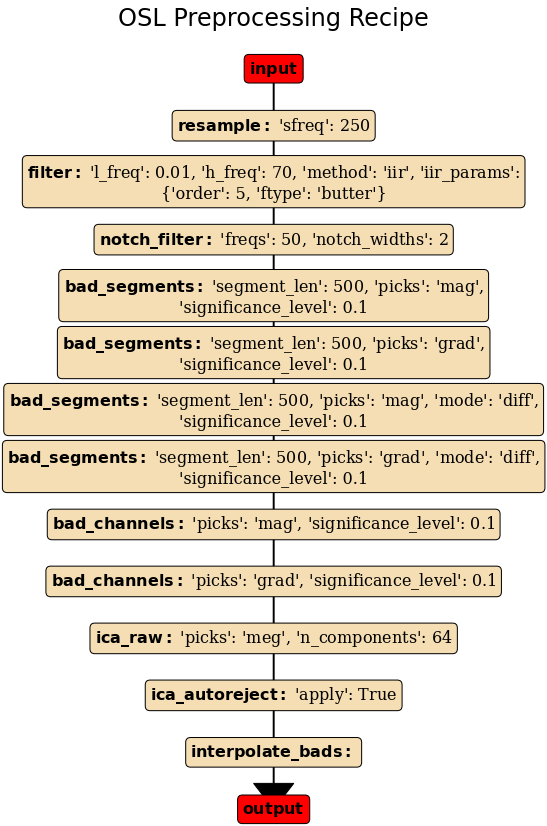

In [4]:
osl.preprocessing.plot_preproc_flowchart(config)

### **Step 2: Coregistration**

In [5]:
#From: https://github.com/OHBA-analysis/osl/blob/main/examples/mrc_meguk/cambridge/2_coregister.py

from osl import source_recon, utils

# Settings
config = """
    source_recon:                        
    - extract_fiducials_from_fif: {}     # ok 
    - compute_surfaces: 
        include_nose: False              
        
    - coregister:
        use_nose: False
        use_headshape: True
        n_init: 50
"""
    
    
# Directories

subject = "/home/olivierb/test/meg_0925_SDMT_tsss_mc/meg_0925_SDMT_tsss_mc_preproc_raw.fif"

# Directory in which we will save the coregistered data
COREG_DIR = "/home/olivierb/coreg"

# Directory to the FSL library, same as the one used in MATLAB, supported by Python
FSL_DIR = "/usr/lib/fsl/6.0"           


# Run coregistration

source_recon.setup_fsl(FSL_DIR)
source_recon.run_src_batch(
    config,
    src_dir=COREG_DIR,
    subjects=['meg_0925_SDMT_tsss_mc_preproc_raw.fif'],   # name of the subject
    preproc_files=[subject],                              # path to preprocessed file
    smri_files=[T1_MNI_niifiles[0]],                      # path to .nii file of the subject
    )

### **Step 3: Source reconstruction (Forward Modelling/Beamforming/Parcellation/Orthogonalisation)**

In [ ]:
from osl import source_recon
# '/home/olivierb/38_parcels.nii' => 38 parcels / sform_code=1

# Settings
config = """
    source_recon:
    - forward_model:
        model: Single Layer                         # ok: Single Shell in MATLAB
    - beamform_and_parcellate:
        freq_range: [1, 80]                         
        chantypes: [mag, grad]                      # standard for MEG
        rank: {meg: 60}                             
        parcellation_file: '/home/olivierb/38_parcels.nii'
        method: spatial_basis                       # ok => spatial_basis or pca => spatial_basis takes into account the weighting of each voxel provided in the parcellation file
        orthogonalisation: symmetric                # ok
"""

# Run beamforming and parcellation
FSL_DIR = "/usr/lib/fsl/6.0" 
COREG_DIR = "/home/olivierb/coreg"
SUBJECT = subject = "/home/olivierb/processed_data/meg_0925_SDMT_tsss_mc/meg_0925_SDMT_tsss_mc_preproc_raw.fif"

source_recon.setup_fsl(FSL_DIR)
source_recon.run_src_batch(
    config,
    src_dir=COREG_DIR,                                     # path to all the /coreg directory !!!!
    subjects=['meg_0925_SDMT_tsss_mc_preproc_raw.fif'],    # name of the subject(s)
    preproc_files=[subject]                                # path to preprocessed file(s)
)   

#### **Plot result of one of parcelated file**

In [47]:
raw = mne.io.read_raw_fif("/home/olivierb/coreg/meg_0925_SDMT_tsss_mc_preproc_raw.fif/parc/parc-raw.fif")

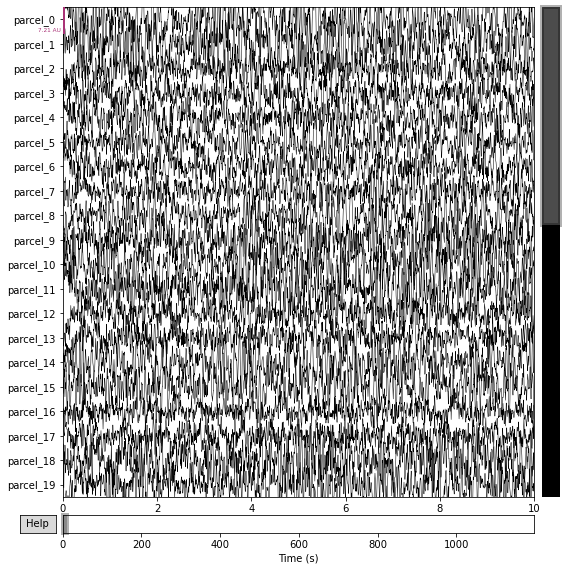

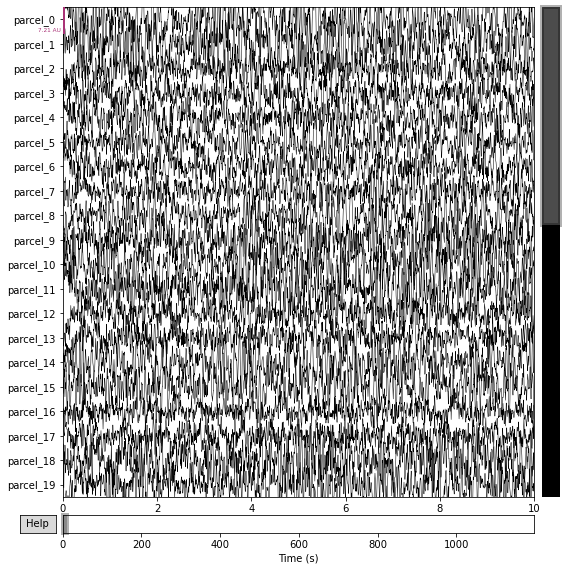

In [48]:
raw.plot()

# **Processing Pipeline - different subject groups in Parallel processing**

Here the entire pipeline is ran for a larger amount of subjects at once. The goal is to process all subject files. I avoid processing all subjects in a single run, in case that an unexpected error occurs.

Several CPU cores can be allocated at the same time to perform the processing of several subjects in parallel (faster).

#### Select subject group to perform analysis on:

In [15]:
from dask.distributed import Client

## To check for correct .fif/.nii pairs
#for i in range(len(fif_files)):
    #print(i, fif_files[i][-21:-17], T1_MNI_niifiles[i][-22:-18])

## 1. index 0-59
#idx_start = 18 
#idx_end = 60
#input_fif_files = fif_files[idx_start:idx_end]

## 2. index 60-115
#idx_start = 60
#idx_end = len(fif_files)
#input_fif_files = fif_files[idx_start:idx_end]

## 3. index 90-115
idx_start = 90
idx_end = len(fif_files)
input_fif_files = fif_files[idx_start:idx_end]

### **Step 1: Preprocessing**

In [ ]:
from osl import preprocessing, utils

# Directory in which we save the preprocessed data
PREPROC_DIR = "/home/olivierb/processed_data"
inputs = input_fif_files 

## Order of preprocessing steps actually matters in the list of dictionaries (config)!

# Settings
config = """
    preproc:
    - resample: {sfreq: 250}
    
    - filter: {l_freq: 0.01, h_freq: 70, method: iir, iir_params: {order: 5, ftype: butter}}
    - notch_filter: {freqs: 50, notch_widths: 2} 

    - bad_segments: {segment_len: 500, picks: mag, significance_level: 0.1}
    - bad_segments: {segment_len: 500, picks: grad, significance_level: 0.1}
    - bad_segments: {segment_len: 500, picks: mag, mode: diff, significance_level: 0.1}
    - bad_segments: {segment_len: 500, picks: grad, mode: diff, significance_level: 0.1}
    - bad_channels: {picks: mag, significance_level: 0.1}
    - bad_channels: {picks: grad, significance_level: 0.1}
    
    - ica_raw: {picks: meg, n_components: 64}
    - ica_autoreject: {apply: true}  
    
    - interpolate_bads: {}
"""
# Setup parallel processing
client = Client(n_workers=4, threads_per_worker=1)

# Main preprocessing
preprocessing.run_proc_batch(
    config,
    inputs,
    outdir=PREPROC_DIR,
    overwrite=True,
    dask_client = True
)

In [18]:
# Prepare subjects and subject names for the remaining steps in the pipeline

# Get the group of preprocessed files
DIR_processed = "/home/olivierb/processed_data/"
all_processed = sorted(glob.glob(DIR_processed + 'meg_*_SDMT_tsss_mc/'))

#get the actual fif files for the current group of subjects
group_processed_fif = []             
for i in range(idx_end - idx_start):
    group_processed_fif.append(sorted(glob.glob(all_processed[idx_start + i] + '*_preproc_raw.fif'))[0])

# Get the names of the subjects of each preprocessed file (the last of part of the path)
group_processed_names = []
for i in range(idx_end - idx_start):
    group_processed_names.append(os.path.basename(group_processed_fif[i]))

# Get the group of T1_MNI.nii files 
group_smri = T1_MNI_niifiles[idx_start:idx_end]
print(len(group_smri))

126


### **Step 2: Coregistration**

In [ ]:
from osl import source_recon, utils
import numpy as np

# Settings
config = """
    source_recon:                        
    - extract_fiducials_from_fif: {}     # ok 
    - fix_headshape_points: {}           # ok
    - compute_surfaces: 
        include_nose: False              
        
    - coregister:
        use_nose: False
        use_headshape: True
        n_init: 50
"""
    
# Directories

# Directory in which we will save the coregistered data
COREG_DIR = "/home/olivierb/coreg"
# Directory to the FSL library, same as the one used in MATLAB, supported by Python
FSL_DIR = "/usr/lib/fsl/6.0"           

# Setup parallel processing
client = Client(n_workers=4, threads_per_worker=1)

# Run coregistration
source_recon.setup_fsl(FSL_DIR)
source_recon.run_src_batch(
    config,
    src_dir=COREG_DIR,
    subjects=group_processed_names,                # name of the subject (preferably the same as the processed .fif file, otherwise creates extra folders)
    preproc_files=group_processed_fif,             # path to preprocessed file
    smri_files=group_smri,                         # path to .nii file of the subject
    dask_client=True
    )

### **Step 3: Source reconstruction (Forward Modelling/Beamforming/Parcellation/Orthogonalisation)**

In [ ]:
from osl import source_recon
#'/home/olivierb/38_parcels.nii' => 38 parcels / sform_code=1

# Settings
config = """
    source_recon:
    - forward_model:
        model: Single Layer                                     # ok: Single Shell in MATLAB
    - beamform_and_parcellate:
        freq_range: [1, 80]                         
        chantypes: [mag, grad]                                  # standard for MEG
        rank: {meg: 60}                             
        parcellation_file: '/home/olivierb/38_parcels.nii'
        method: spatial_basis                                   # ok => spatial_basis or pca
        orthogonalisation: None                                 # ok (if you want to apply orthog. -> symmetric)
"""

# Run beamforming and parcellation
FSL_DIR = "/usr/lib/fsl/6.0" 
COREG_DIR = "/home/olivierb/coreg"

# Setup parallel processing
client = Client(n_workers=4, threads_per_worker=1)

## !!!!!!!!!!!!! Parallel processing fails for source reconstruction for some reason --> do it for all files in sequences

source_recon.setup_fsl(FSL_DIR)
source_recon.run_src_batch(
    config,
    src_dir=COREG_DIR,                                     # path to all the /coreg directory !!!!
    subjects=group_processed_names,                        # name of the subject(s)
    preproc_files=group_processed_fif,                     # path to preprocessed file(s)
    #dask_client=True
)   

### **Before we can do the Sign-Flipping (Step 4):**
### **1 subject (ID 0995) is missing ECG/EOG channels, the automated ICA artifact rejection can not be executed**

### For the single subject that did not have EOG/ECG channels

In [ ]:
from osl import preprocessing, utils

# Directory in which we save the preprocessed data
PREPROC_DIR = "/home/olivierb/processed_data"

## Order of preprocessing steps actually matters in the list of dictionaries (config)!

# Settings
config = """
    preproc:
    - resample: {sfreq: 250}
    
    - filter: {l_freq: 0.01, h_freq: 70, method: iir, iir_params: {order: 5, ftype: butter}}
    - notch_filter: {freqs: 50, notch_widths: 2} 
    
    - bad_segments: {segment_len: 500, picks: mag, significance_level: 0.1}
    - bad_segments: {segment_len: 500, picks: grad, significance_level: 0.1}
    - bad_segments: {segment_len: 500, picks: mag, mode: diff, significance_level: 0.1}
    - bad_segments: {segment_len: 500, picks: grad, mode: diff, significance_level: 0.1}
    - bad_channels: {picks: mag, significance_level: 0.1}
    - bad_channels: {picks: grad, significance_level: 0.1}
    
    - interpolate_bads: {}
    
    # NO ICA FOR SUBJECT 0995 => NO EOG CHANNELS FOUND
    #- ica_raw: {picks: meg, n_components: 64}
    #- ica_autoreject: {apply: true}  

"""

# Main preprocessing
preprocessing.run_proc_batch(
    config,
    fif_files[7],
    outdir=PREPROC_DIR,
    overwrite=True,
)

### **Manual ICA - subject 0995**
##### be careful! ICA should be performed on the .fif file after filtering/referencing etc. (Don't accidentally select the file with the already applied manual ICA on it)

In [9]:
# Load the sinlge subject
raw = mne.io.read_raw_fif('/home/olivierb/processed_data/meg_0995_SDMT_tsss_mc/meg_0995_SDMT_tsss_mc_preproc_raw.fif', preload=True)

In [10]:
ica = mne.preprocessing.ICA(n_components=64, random_state = 0)
raw_ica = raw.copy()
ica.fit(raw_ica)

<ICA | raw data decomposition, method: fastica (fit in 76 iterations on 239001 samples), 64 ICA components (306 PCA components available), channel types: mag, grad, no sources marked for exclusion>

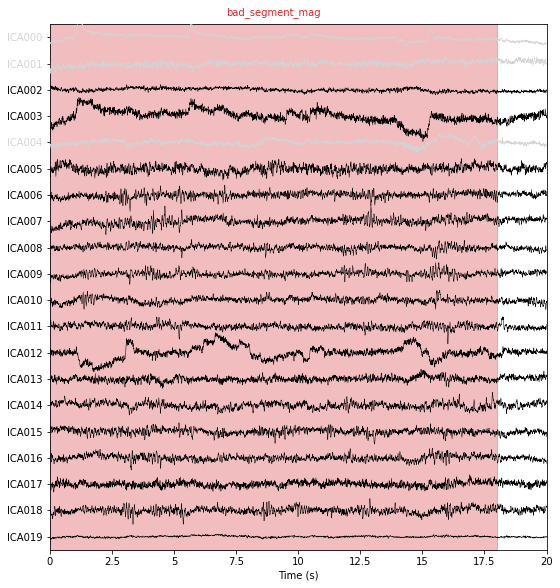

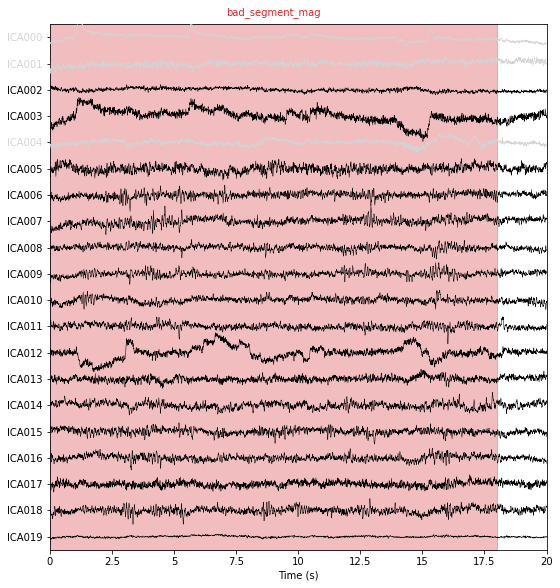

In [17]:
ica.plot_sources(raw_ica, show_scrollbars=False)

/tmp/ipykernel_945248/150138342.py:2: RuntimeWarning: (X, Y) fit (3.1, 20.1) more than 20 mm from head frame origin
  ica.plot_components()


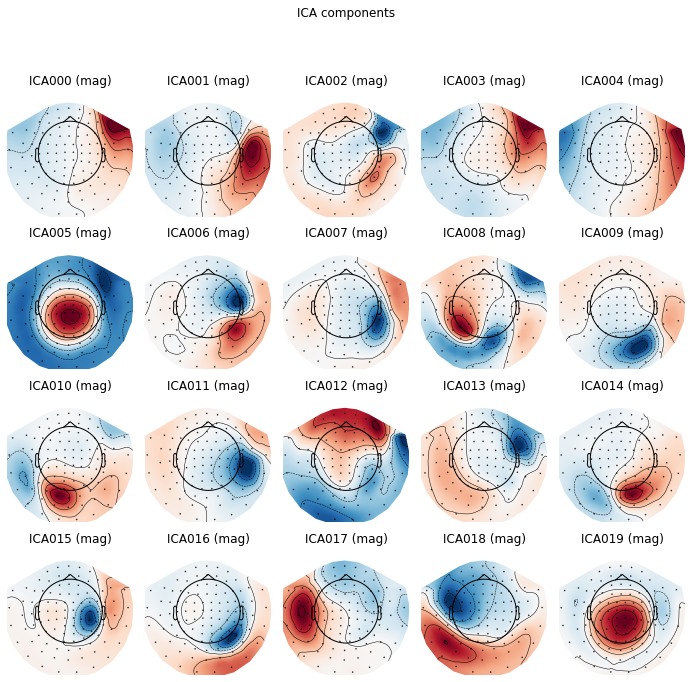

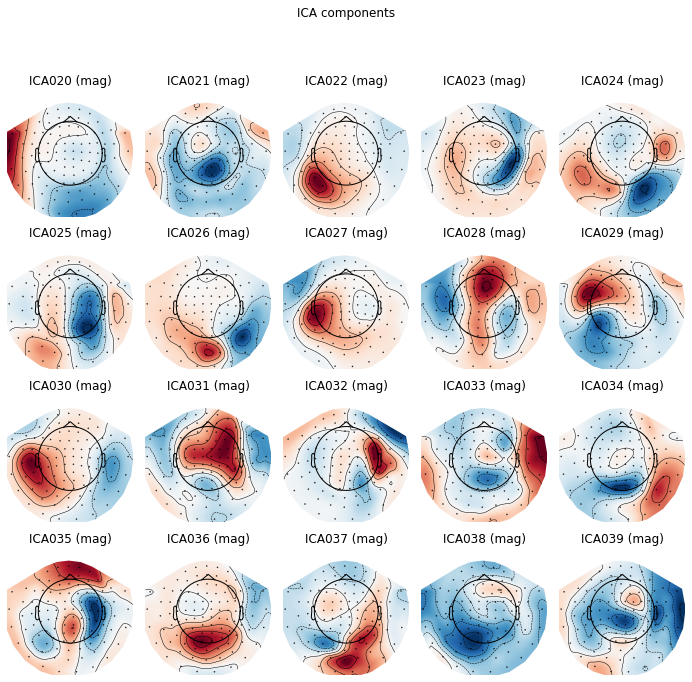

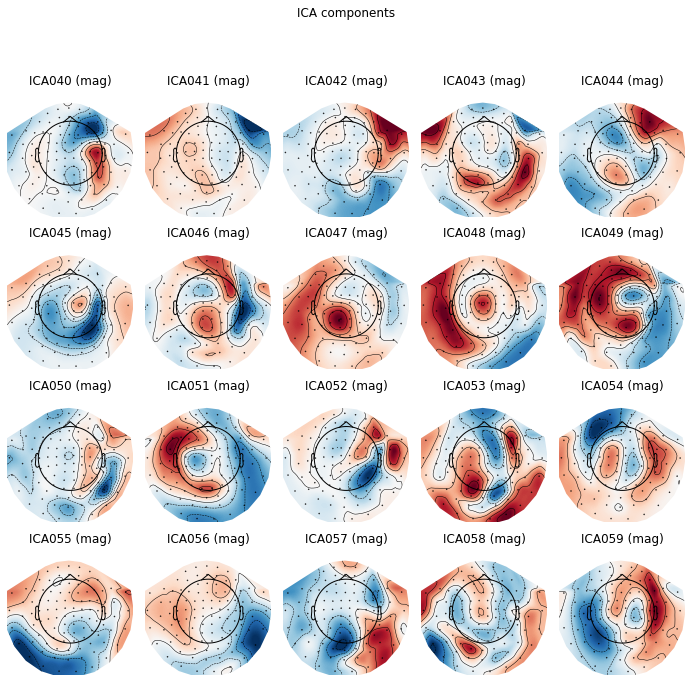

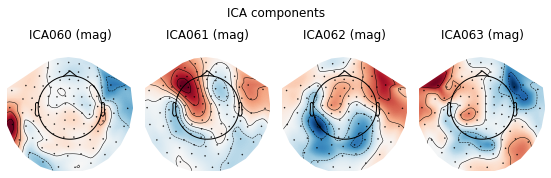

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 561.6x187.56 with 4 Axes>]

In [15]:
%matplotlib inline
ica.plot_components()

/tmp/ipykernel_945248/2658260692.py:2: RuntimeWarning: (X, Y) fit (3.1, 20.1) more than 20 mm from head frame origin
  ica.plot_properties(raw, picks=4, psd_args={'fmax': 35.})


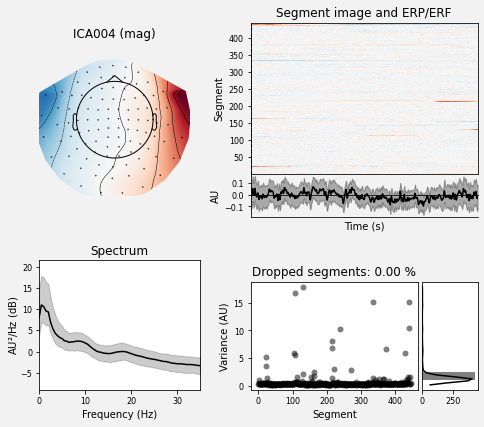

[<Figure size 504x432 with 6 Axes>]

In [45]:
%matplotlib inline
ica.plot_properties(raw, picks=4, psd_args={'fmax': 35.})

In [46]:
#ICA000, ICA001, ICA004
artifact_picks = 0,1,3,4

#Removing the ICA components containing eyeblinks and eyemovements
ica.exclude = artifact_picks  # indices chosen based on various plots above

reconst_raw_1 = raw.copy()
ica.apply(reconst_raw_1)

<Raw | meg_0995_SDMT_tsss_mc_preproc_raw.fif, 330 x 274500 (1098.0 s), ~696.4 MB, data loaded>

In [47]:
reconst_raw_1.save('/home/olivierb/processed_data/meg_0995_SDMT_tsss_mc/meg_0995_SDMT_tsss_mc_preproc_raw.fif', overwrite=True)

In [5]:
from osl import source_recon, utils

# Settings
config = """
    source_recon:                        
    - extract_fiducials_from_fif: {}     # ok 
    - compute_surfaces: 
        include_nose: False              
        
    - coregister:
        use_nose: False
        use_headshape: True
        n_init: 50
"""
    
# Directories

subject = "/home/olivierb/test/meg_0995_SDMT_tsss_mc/meg_0995_SDMT_tsss_mc_preproc_raw.fif"

# Directory in which we will save the coregistered data
COREG_DIR = "/home/olivierb/coreg"

# Directory to the FSL library, same as the one used in MATLAB, supported by Python
FSL_DIR = "/usr/lib/fsl/6.0"           


# Run coregistration

source_recon.setup_fsl(FSL_DIR)
source_recon.run_src_batch(
    config,
    src_dir=COREG_DIR,
    subjects=['meg_0995_SDMT_tsss_mc_preproc_raw.fif'],   # name of the subject
    preproc_files=[subject],                              # path to preprocessed file
    smri_files=[T1_MNI_niifiles[7]],                      # path to .nii file of the subject
    )

In [ ]:
from osl import source_recon
# '/home/olivierb/38_parcels.nii' => 38 parcels / sform_code=1

# Settings
config = """
    source_recon:
    - forward_model:
        model: Single Layer                         # ok: Single Shell in MATLAB
    - beamform_and_parcellate:
        freq_range: [1, 80]                         
        chantypes: [mag, grad]                      # standard for MEG
        rank: {meg: 60}                             
        parcellation_file: '/home/olivierb/38_parcels.nii'
        method: spatial_basis                       # ok => spatial_basis or pca => spatial_basis takes into account the weighting of each voxel provided in the parcellation file
        orthogonalisation: symmetric                # ok
"""

# Run beamforming and parcellation
FSL_DIR = "/usr/lib/fsl/6.0" 
COREG_DIR = "/home/olivierb/coreg"
SUBJECT = subject = "/home/olivierb/processed_data/meg_0995_SDMT_tsss_mc/meg_0995_SDMT_tsss_mc_preproc_raw.fif"

source_recon.setup_fsl(FSL_DIR)
source_recon.run_src_batch(
    config,
    src_dir=COREG_DIR,                                     # path to all the /coreg directory !!!!
    subjects=['meg_0995_SDMT_tsss_mc_preproc_raw.fif'],    # name of the subject(s)
    preproc_files=[subject]                                # path to preprocessed file(s)
)   

### **Step 4: Sign-flipping (all files together)**

In [ ]:
# To fix dipole sign amiguity.

from dask.distributed import Client
from osl import utils
from osl.source_recon import find_template_subject, run_src_batch, setup_fsl

# Directories
SRC_DIR = "/home/olivierb/coreg"
FSL_DIR = "/usr/lib/fsl/6.0" 

# Get the parceled data
DIR_parceled = "/home/olivierb/coreg/"
all_parceled = sorted(glob.glob(DIR_parceled + 'meg_*_SDMT_tsss_mc_preproc_raw.fif/'))  # needs to be like this (don't include "parc/parc_raw.fif")
subjects = all_parceled

setup_fsl(FSL_DIR)

# Find a good template subject to align other subjects to
template = find_template_subject(SRC_DIR, subjects, n_embeddings=15, standardize=True)

#### Get the subject names for all processed files

In [ ]:
all_succesful_parceled = sorted(glob.glob('/home/olivierb/coreg/' + 'meg_*_SDMT_tsss_mc_preproc_raw.fif/parc/parc-raw.fif'))

names_subjects = []

# Gets you all the subject names for which the data was succesfully parceled
for file_path in all_succesful_parceled:
    # Split the string by '/'
    parts = file_path.split('/')
    # Extract the desired part (second-to-last element)
    desired_part = parts[-3]
    names_subjects.append(desired_part)

In [ ]:
# Settings for batch processing
config = f"""
        source_recon:
        - fix_sign_ambiguity:
            template: {template}
            n_embeddings: 15
            standardize: True
            n_init: 5
            n_iter: 500
            max_flips: 20
"""

# Setup parallel processing
DIR_parceled = "/home/olivierb/coreg/"

# Do the sign flipping - Apply the template
run_src_batch(config, SRC_DIR, names_subjects) #dask_client=True)

### **Extra: Function to overwrite sform_code of a .nii file (can be used on both MRI scans & parcelation files)**

This is required due to a mismatch in sform_code for the **parcellation file** (gives an error in osl python):
- Original sform_code = 4 (normalized coordinates)
- Required sform_code = 1 (scanner)based anatomical coordinates)

Meaning of the sform codes: https://nifti.nimh.nih.gov/nifti-1/documentation/nifti1fields/nifti1fields_pages/qsform.html/document_view

In [20]:
import nibabel as nib
import numpy as np
import pandas as pd

## Parcellation files
#(original_file_path = "/home/olivierb/osl/source_recon/parcellation/files/fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz", output_file_path = '/home/olivierb/38_parcels.nii')

# Function to overwrite the sform_code of an existing .nii file
def overwrite_sformcode(original_file_path, output_file_path):
    
    # Load the NIfTI image
    nii_img = nib.load(original_file_path)

    # Get the image data and affine matrix
    data = nii_img.get_fdata()
    affine = nii_img.affine

    # Create a new NIfTI image with the modified sform_code
    new_sformcode = 1  # Set to the desired value
    new_header = nii_img.header.copy()
    new_header.set_sform(affine, code=new_sformcode)

    # Create a new image using the modified data and header
    nii_img_with_modified_header = nib.Nifti1Image(data, affine, header=new_header)

    # Save the new image to a file
    nib.save(nii_img_with_modified_header, output_file_path)

    # Reload the saved image
    loaded_img = nib.load(output_file_path)

    # Check the sform_code of the loaded image
    print(loaded_img.header['sform_code'])
    
    return

### **Extra: Explore and visualise parcellation file**

#### Plot parcellation for visualisation

In [50]:
from nilearn import image

nii_img = image.load_img("/home/fahimeha/PhD/preprocessing/parcellation/fmri_d100_parcellation_with_3PCC_ips_reduced_2mm_ss5mm_ds8mm_adj.nii")

print(nii_img.shape)

one_volume = image.index_img(nii_img, 3)
print(one_volume.shape)

(23, 27, 23, 42)
(23, 27, 23)


In [51]:
from nilearn import image
path_parcel = "/home/olivierb/osl/source_recon/parcellation/files/fmri_d100_parcellation_with_PCC_reduced_2mm_ss5mm_ds8mm.nii.gz"
nii_img = image.load_img(path_parcel)
print(nii_img.shape)

(23, 27, 23, 38)


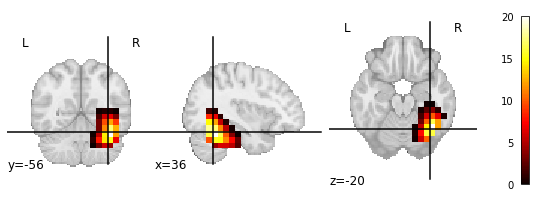

In [52]:
from nilearn import plotting

plotting.plot_stat_map(one_volume)

In [21]:
import nilearn

In [22]:
from nilearn.regions import connected_regions
from nilearn import datasets, plotting
import nibabel as nib
atlas = nib.load("/home/olivierb/38_parcels.nii")

In [23]:
region_labels = connected_regions(atlas)

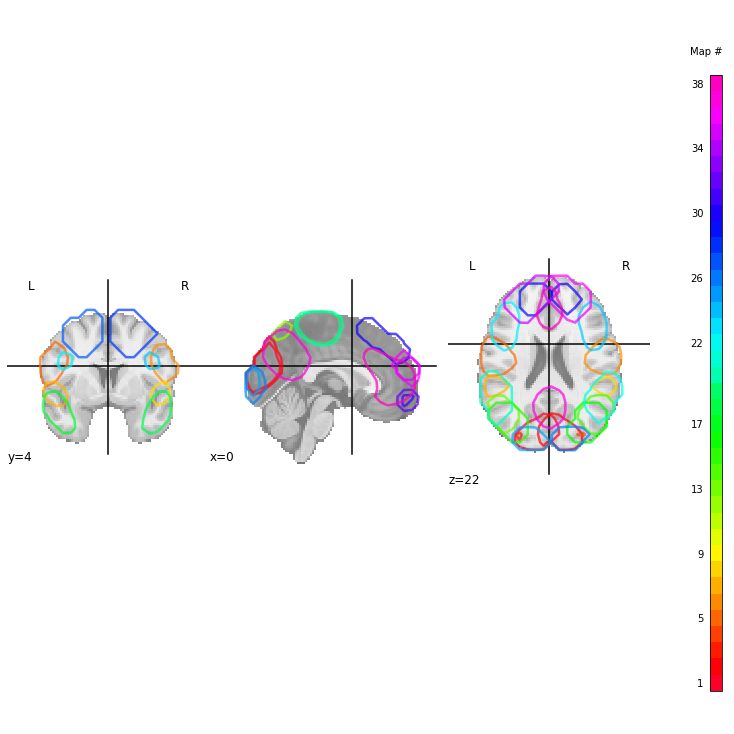

In [24]:
import matplotlib.pyplot as plt
nilearn.plotting.plot_prob_atlas(atlas, figure=plt.figure(figsize=(10,10)), annotate=True, colorbar=True, view_type='contours')

#### Extract parcel names for the parcellation file

In [25]:
## Parcel names extract

# Open the .txt file for reading
file_path = "/home/olivierb/Downloads/Parcels_38_names.txt"
with open(file_path, 'r') as file:
    lines = file.readlines()

# Strip any leading/trailing whitespace and create a list of strings
parcel_names = [line.strip() for line in lines]

# Print the list of strings
print(parcel_names)

# Parcel indices (how the channel names are stored in the Python parceled .fif files)
parcel_idx= []
for i in range(len(parcel_names)):        # 38 parcels
    parcel_idx.append('parcel_' + str(i))
print(parcel_idx)

['L Cuneus', 'R Cuneus', 'L Inf Occ', 'R Inf Occ', 'L Supramarginal', 'R Supramarginal', 'L Sup Temp', 'R Sup Temp', 'L Lat SMC', 'R Lat SMC', 'L Sup Parietal', 'R Sup Parietal', 'L Middle Occ', 'R Middle Occ', 'L Sup Occ', 'R Sup Occ', 'L Ant Temp', 'R Ant Temp', 'L Medial SMC', 'R Medial SMC', 'L Angular', 'R Angular', 'L VL PFC', 'R VL PFC', 'L Occ pole', 'R Occ pole', 'L Sup PFC', 'R Sup PFC', 'L Sup Dorsal PFC', 'R Sup Dorsal PFC', 'L Orbitofrontal', 'R Orbitofrontal', 'L Post Temp', 'R Post Temp', 'L Inf Dorsal PFC', 'R Inf Dorsal PFC', 'Medial PFC', 'Posterior Cingulate Cortex']
['parcel_0', 'parcel_1', 'parcel_2', 'parcel_3', 'parcel_4', 'parcel_5', 'parcel_6', 'parcel_7', 'parcel_8', 'parcel_9', 'parcel_10', 'parcel_11', 'parcel_12', 'parcel_13', 'parcel_14', 'parcel_15', 'parcel_16', 'parcel_17', 'parcel_18', 'parcel_19', 'parcel_20', 'parcel_21', 'parcel_22', 'parcel_23', 'parcel_24', 'parcel_25', 'parcel_26', 'parcel_27', 'parcel_28', 'parcel_29', 'parcel_30', 'parcel_31', 

/home/olivierb/.local/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:144: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figure, figsize=figsize,


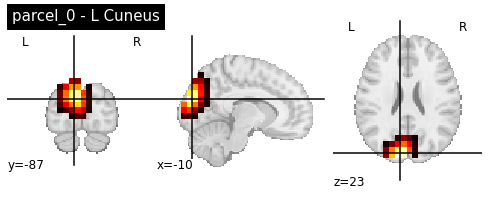

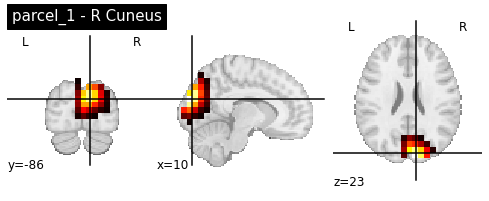

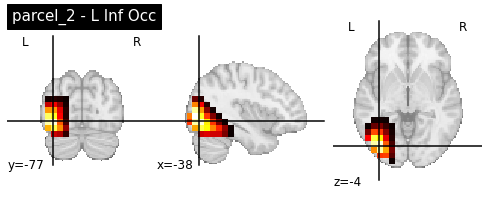

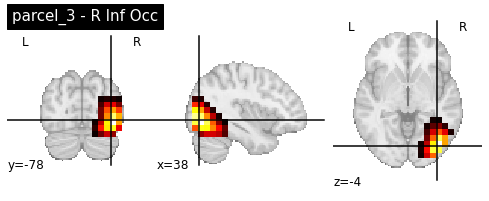

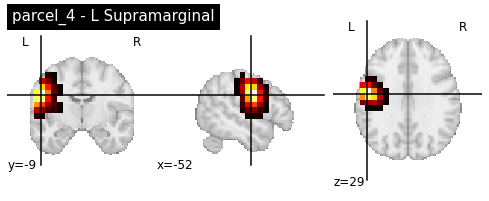

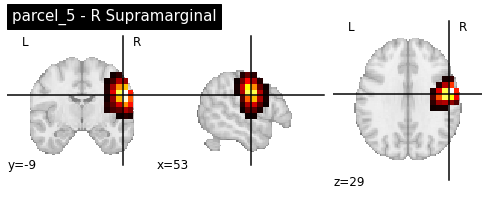

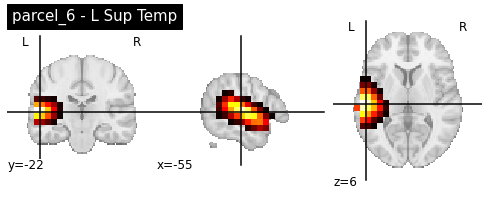

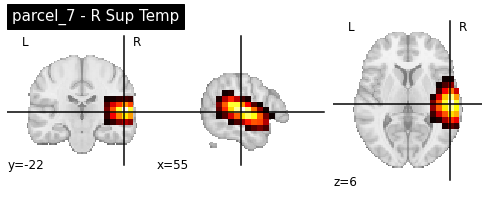

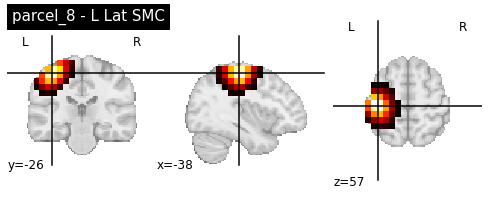

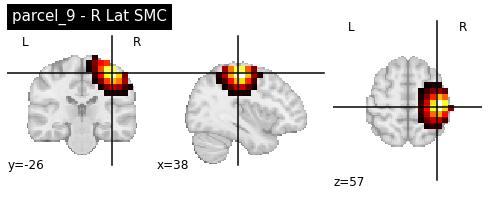

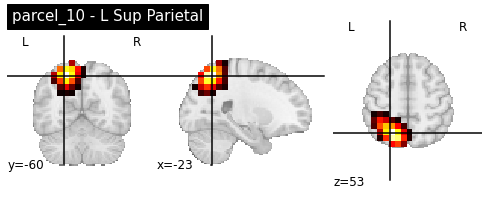

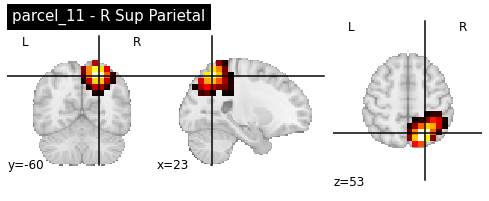

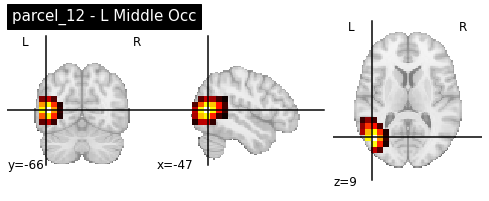

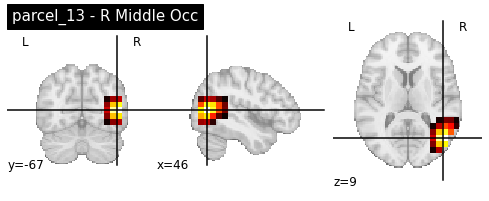

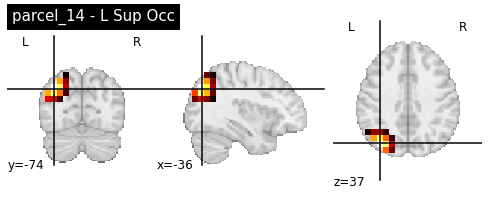

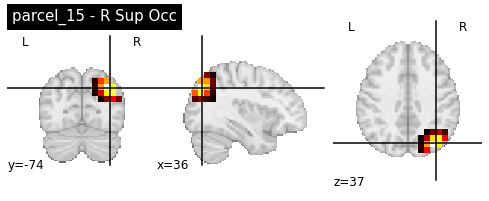

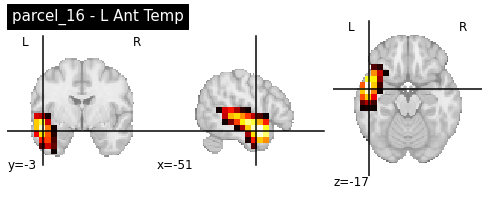

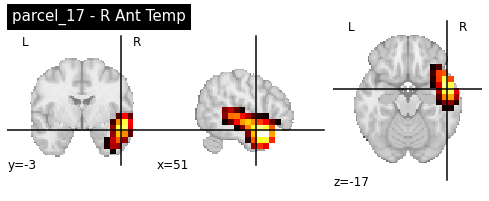

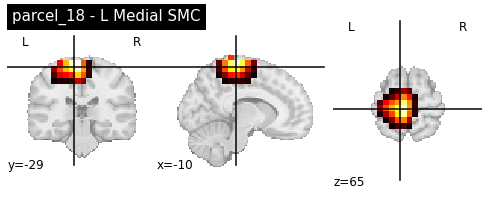

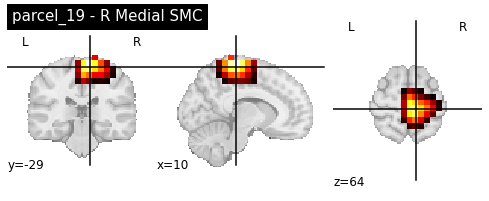

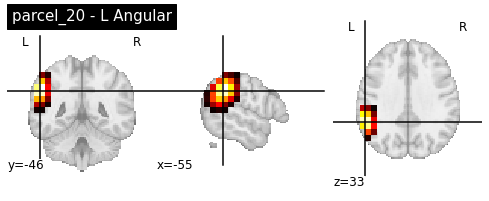

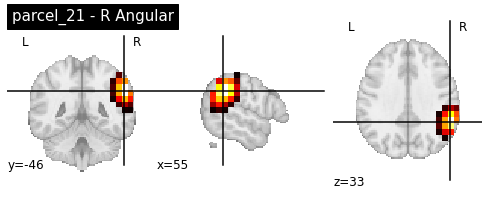

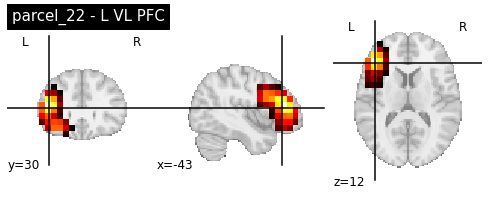

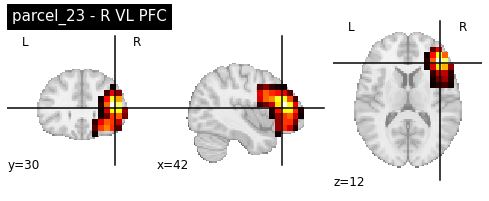

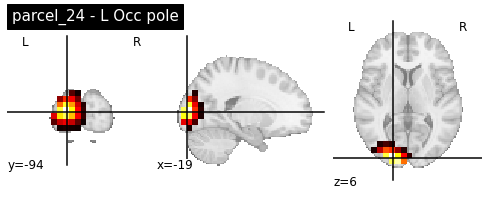

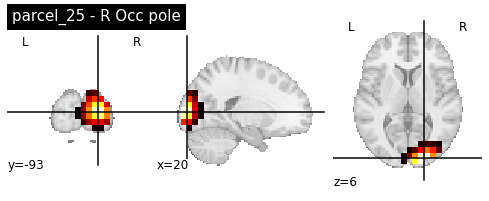

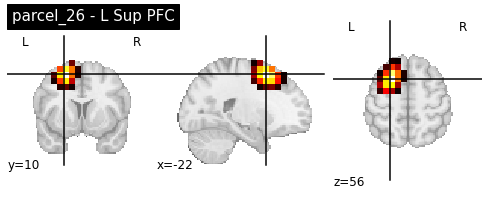

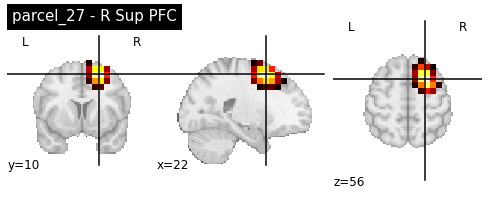

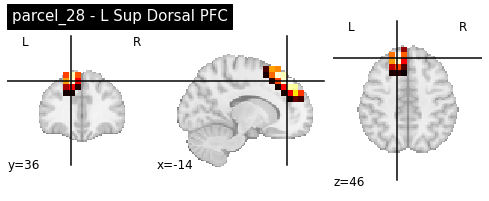

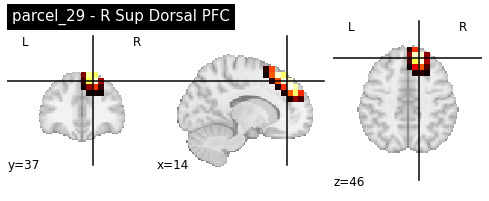

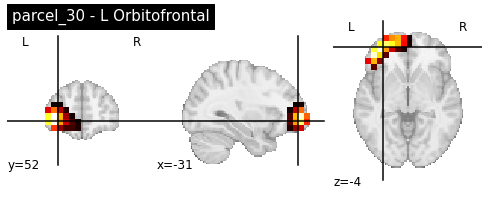

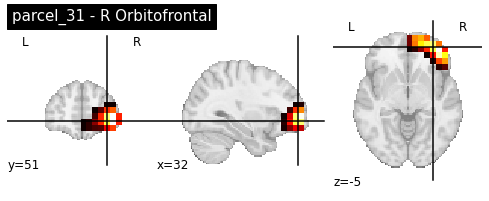

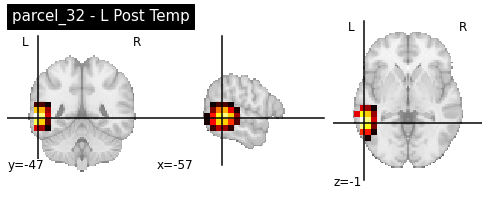

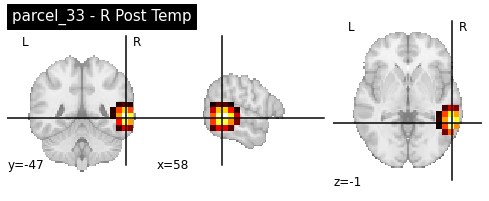

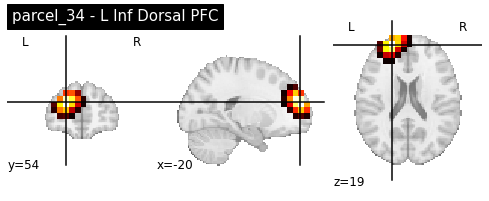

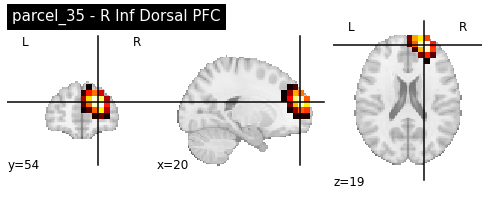

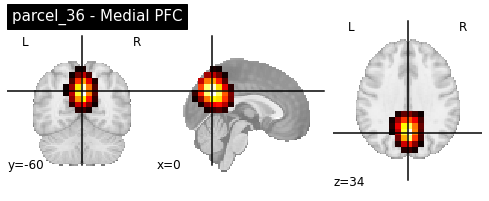

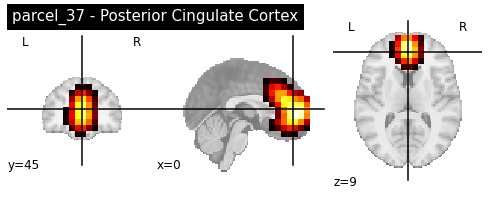

In [26]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(atlas)):
    plot_stat_map(
        cur_img,
        title=f"{parcel_idx[i]} - {parcel_names[i]}",
        colorbar=False,
    )
    
# takes a little while to plot everything